In [173]:
import os
import numpy as np
import jams
import librosa
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [174]:
annotation_folder = "audio/GuitarSet/annotation/"
audio_folder = "audio/GuitarSet/audio/"
output = {}
hop_length = 512
sr_curr = 22050
cqt_n_bins = 288
cqt_bins_per_octave = 36
string_midi_pitches = [40,45,50,55,59,64]
highest_fret = 19
num_classes = highest_fret + 2
matrix = np.zeros(shape=(6, 21)).astype(int)

In [175]:
def preprocess_audio(data):
    data = data.astype(float)
    data = librosa.util.normalize(data)
    data = np.abs(librosa.cqt(data,
                              hop_length=hop_length,
                              sr=sr_curr,
                              n_bins=cqt_n_bins,
                              bins_per_octave=cqt_bins_per_octave))

    return data

In [176]:
def correct_numbering(n):
    n += 1
    if n < 0 or n > highest_fret+1:
        n = 0
    return n

def one_hot_encode(label):
    return to_categorical(label, num_classes)

In [177]:
def process_label(label):
    label = [correct_numbering(n) for n in label]
    return one_hot_encode(label)

In [178]:
def process_labels(labels):
    return np.array([process_label(label) for label in labels])

In [179]:
def load_data_from_file(filename):
    output = {}
    file_audio = audio_folder + filename + "_mic.wav"
    file_anno = annotation_folder + filename + ".jams"
    jam = jams.load(file_anno)
    data, _ = librosa.load(file_audio, sr=sr_curr)

    # preprocess audio, store in output dict
    output["spec"] = np.swapaxes(preprocess_audio(data),0,1)

    # construct labels
    frame_indices = range(len(output["spec"]))
    times = librosa.frames_to_time(frame_indices, sr = sr_curr, hop_length=hop_length)

    # loop over all strings and sample annotations
    labels = []
    for string_num in range(6):
        anno = jam.annotations["note_midi"][string_num]
        string_label_samples = anno.to_samples(times)
        # replace midi pitch values with fret numbers
        for i in frame_indices:
            if string_label_samples[i] == []:
                string_label_samples[i] = -1
            else:
                string_label_samples[i] = int(round(string_label_samples[i][0]) - string_midi_pitches[string_num])
        labels.append([string_label_samples])

    labels = np.array(labels)
    # remove the extra dimension
    labels = np.squeeze(labels)
    labels = np.swapaxes(labels,0,1)

    # clean labels
    labels = process_labels(labels)

    # store and return
    output["tab"] = labels
    labels = labels.astype(int)
    sum_labels = np.zeros((6, 21)).astype(int)
    for label in labels:
        sum_labels += label
    return sum_labels

In [180]:
for file in os.listdir(annotation_folder):
    file = file.replace('.jams', '')
    if file.startswith('05'):
        l = load_data_from_file(file)
        matrix += l
        print(f"file {file} done")

file 05_BN1-129-Eb_comp done
file 05_BN1-129-Eb_solo done
file 05_BN1-147-Gb_comp done
file 05_BN1-147-Gb_solo done
file 05_BN2-131-B_comp done
file 05_BN2-131-B_solo done
file 05_BN2-166-Ab_comp done
file 05_BN2-166-Ab_solo done
file 05_BN3-119-G_comp done
file 05_BN3-119-G_solo done
file 05_BN3-154-E_comp done
file 05_BN3-154-E_solo done
file 05_Funk1-114-Ab_comp done
file 05_Funk1-114-Ab_solo done
file 05_Funk1-97-C_comp done
file 05_Funk1-97-C_solo done
file 05_Funk2-108-Eb_comp done
file 05_Funk2-108-Eb_solo done
file 05_Funk2-119-G_comp done
file 05_Funk2-119-G_solo done
file 05_Funk3-112-C#_comp done
file 05_Funk3-112-C#_solo done
file 05_Funk3-98-A_comp done
file 05_Funk3-98-A_solo done
file 05_Jazz1-130-D_comp done
file 05_Jazz1-130-D_solo done
file 05_Jazz1-200-B_comp done
file 05_Jazz1-200-B_solo done
file 05_Jazz2-110-Bb_comp done
file 05_Jazz2-110-Bb_solo done
file 05_Jazz2-187-F#_comp done
file 05_Jazz2-187-F#_solo done
file 05_Jazz3-137-Eb_comp done
file 05_Jazz3-137-Eb_

In [181]:
print(matrix)

[[68204  1681  1355   944  1647  1514  1071  1320   755   229     6    34
      0     0     0     0     0     0     0     0     0]
 [62618   501   844  1856  2251  3399  1681  1821  1668  1555   123   289
     37   110     7     0     0     0     0     0     0]
 [55378  1100   733  2704  3325  2562  2138  3378  2320  1787  1385  1247
    512   135    31    11    14     0     0     0     0]
 [49426  1201  1861  1180  3252  2822  3086  4795  3691  2870  1738  1898
    411   493    36     0     0     0     0     0     0]
 [49886  1146  1596  2502  1182  3539  2962  4454  2515  2763  2329  1788
   1054   484   508    11    41     0     0     0     0]
 [68724   117   231   619   814   829  1103  1211   988  1294   818  1127
    296   310   247     8    24     0     0     0     0]]


In [182]:
EStringLabels = matrix[0].tolist()[1:]
AStringLabels = matrix[1].tolist()[1:]
DStringLabels = matrix[2].tolist()[1:]
GStringLabels = matrix[3].tolist()[1:]
BStringLabels = matrix[4].tolist()[1:]
eStringLabels = matrix[5].tolist()[1:]
print(f"E string: {EStringLabels}")
print(f"A string: {AStringLabels}")
print(f"D string: {DStringLabels}")
print(f"G string: {GStringLabels}")
print(f"B string: {BStringLabels}")
print(f"e string: {eStringLabels}")

E string: [1681, 1355, 944, 1647, 1514, 1071, 1320, 755, 229, 6, 34, 0, 0, 0, 0, 0, 0, 0, 0, 0]
A string: [501, 844, 1856, 2251, 3399, 1681, 1821, 1668, 1555, 123, 289, 37, 110, 7, 0, 0, 0, 0, 0, 0]
D string: [1100, 733, 2704, 3325, 2562, 2138, 3378, 2320, 1787, 1385, 1247, 512, 135, 31, 11, 14, 0, 0, 0, 0]
G string: [1201, 1861, 1180, 3252, 2822, 3086, 4795, 3691, 2870, 1738, 1898, 411, 493, 36, 0, 0, 0, 0, 0, 0]
B string: [1146, 1596, 2502, 1182, 3539, 2962, 4454, 2515, 2763, 2329, 1788, 1054, 484, 508, 11, 41, 0, 0, 0, 0]
e string: [117, 231, 619, 814, 829, 1103, 1211, 988, 1294, 818, 1127, 296, 310, 247, 8, 24, 0, 0, 0, 0]


In [183]:
def plot_distribution(distribution, labels, title):
    plt.figure(figsize=(12,6))
    plt.bar(labels, distribution, color='purple', alpha=0.7)
    plt.title(title)
    plt.xlabel('Note midi')
    plt.ylabel('Apariții')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

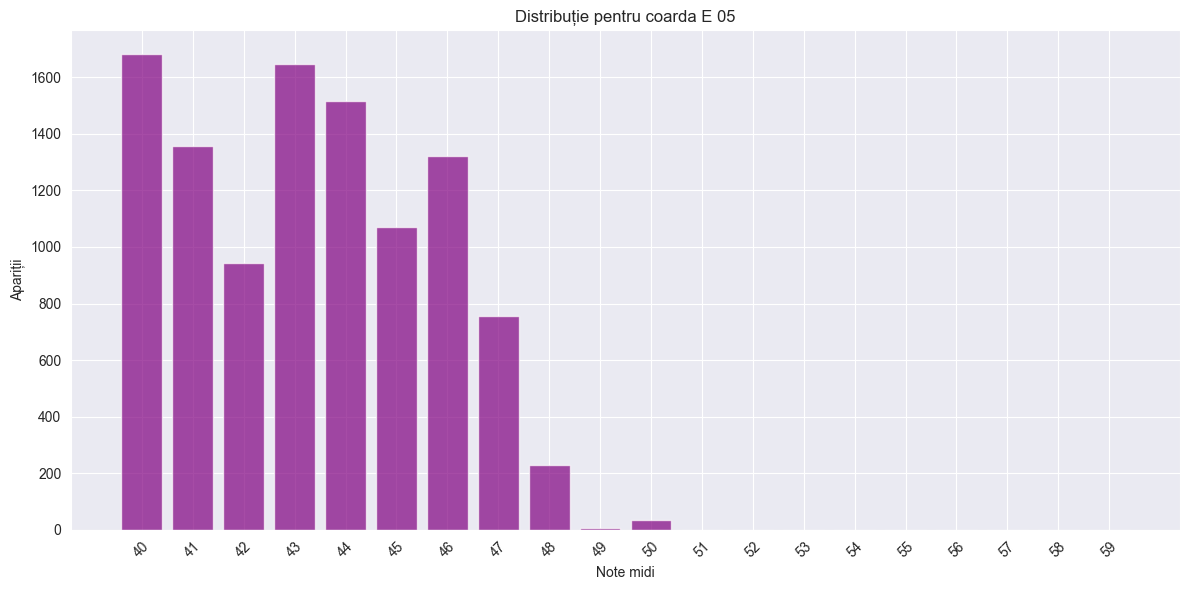

In [184]:
E_labels = [str(i) for i in range(string_midi_pitches[0], string_midi_pitches[0] + highest_fret + 1)]

plot_distribution(EStringLabels, E_labels, title='Distribuție pentru coarda E 05')

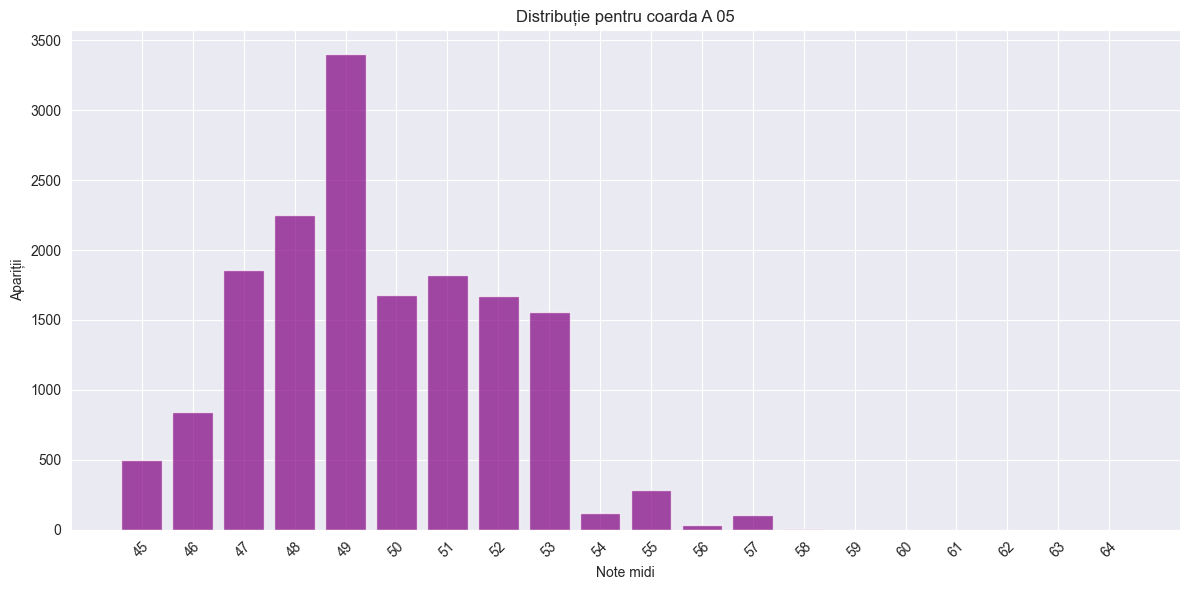

In [185]:
A_labels = [str(i) for i in range(string_midi_pitches[1], string_midi_pitches[1] + highest_fret + 1)]

plot_distribution(AStringLabels, A_labels, title='Distribuție pentru coarda A 05')

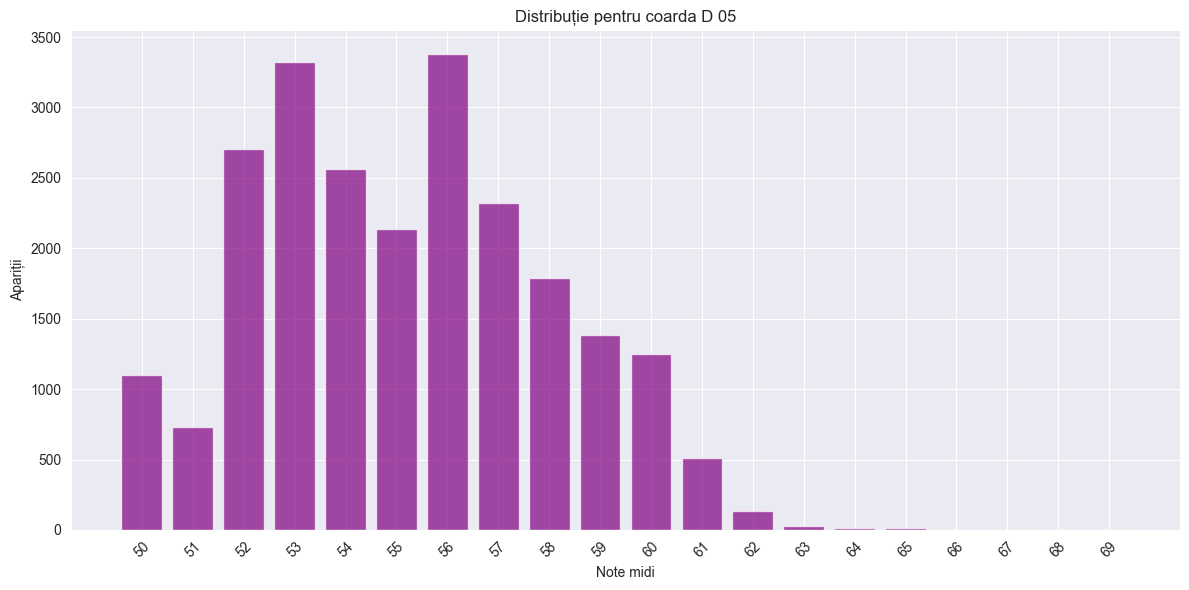

In [186]:
D_labels = [str(i) for i in range(string_midi_pitches[2], string_midi_pitches[2] + highest_fret + 1)]

plot_distribution(DStringLabels, D_labels, title='Distribuție pentru coarda D 05')

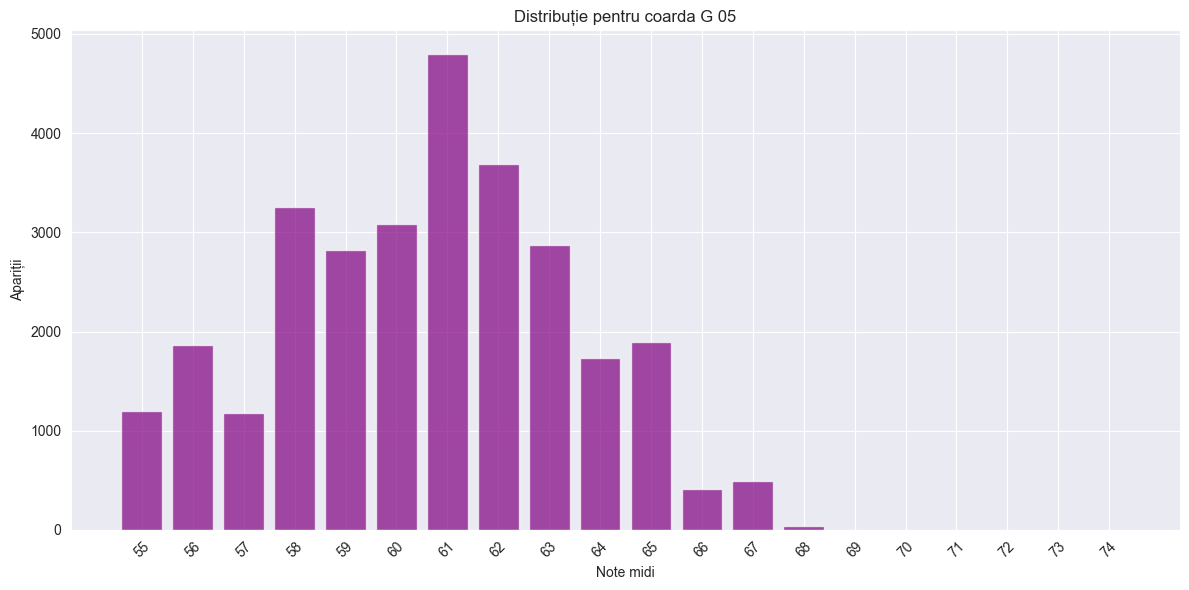

In [187]:
G_labels = [str(i) for i in range(string_midi_pitches[3], string_midi_pitches[3] + highest_fret + 1)]

plot_distribution(GStringLabels, G_labels, title='Distribuție pentru coarda G 05')

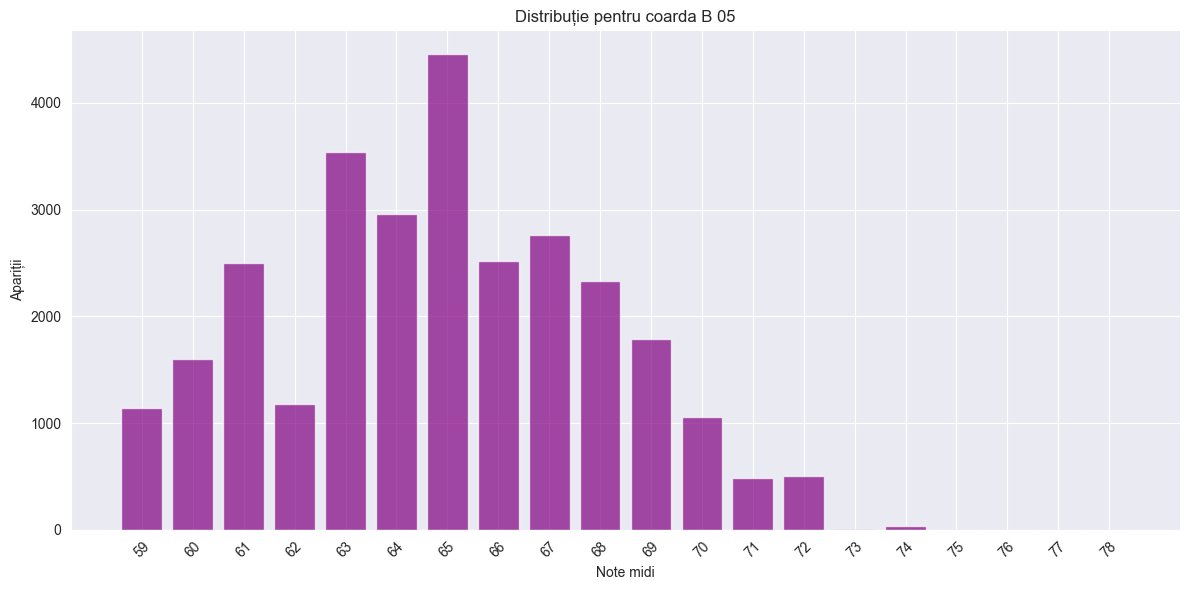

In [188]:
B_labels = [str(i) for i in range(string_midi_pitches[4], string_midi_pitches[4] + highest_fret + 1)]

plot_distribution(BStringLabels, B_labels, title='Distribuție pentru coarda B 05')

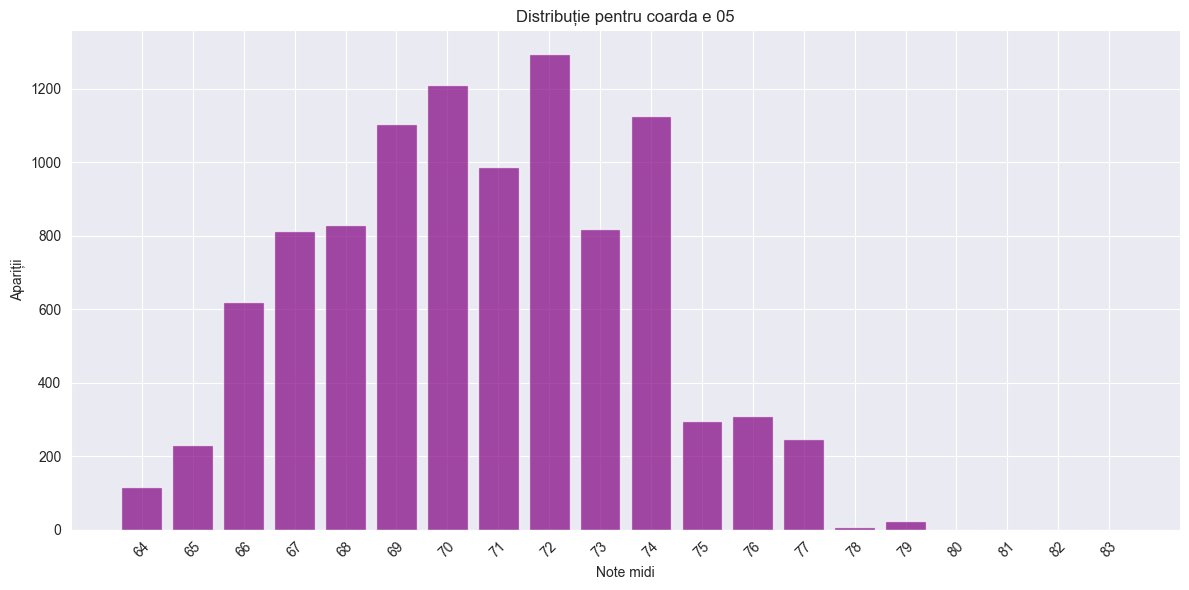

In [189]:
e_labels = [str(i) for i in range(string_midi_pitches[5], string_midi_pitches[5] + highest_fret + 1)]

plot_distribution(eStringLabels, e_labels, title='Distribuție pentru coarda e 05')

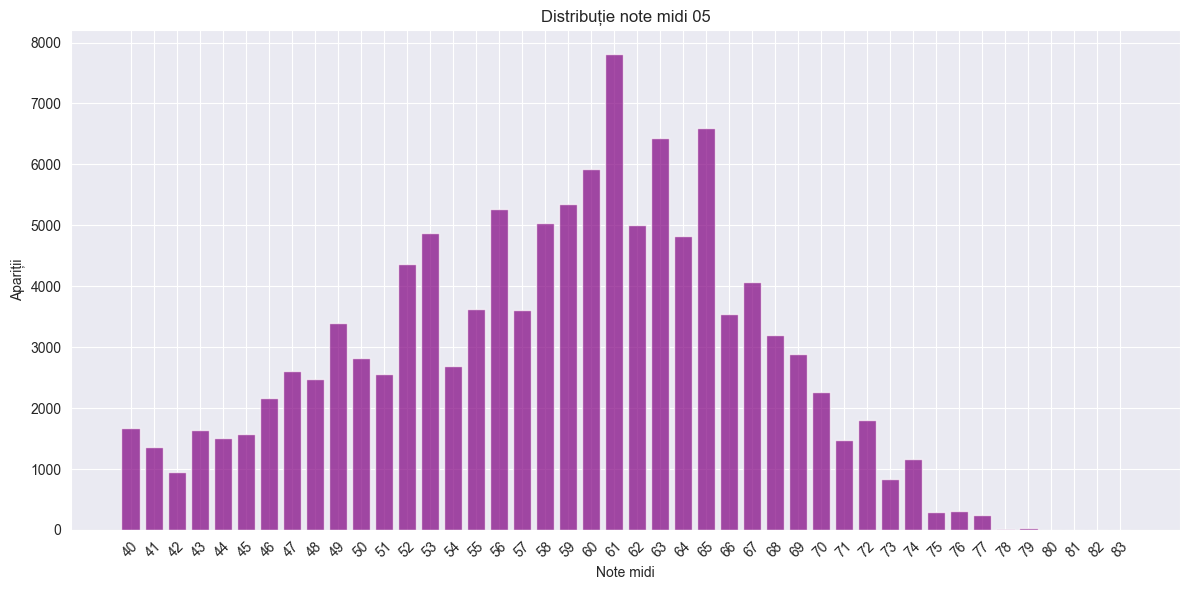

[1681.0, 1355.0, 944.0, 1647.0, 1514.0, 1572.0, 2164.0, 2611.0, 2480.0, 3405.0, 2815.0, 2554.0, 4372.0, 4880.0, 2685.0, 3628.0, 5276.0, 3610.0, 5046.0, 5353.0, 5929.0, 7809.0, 5008.0, 6440.0, 4828.0, 6597.0, 3545.0, 4070.0, 3194.0, 2891.0, 2265.0, 1472.0, 1802.0, 829.0, 1168.0, 296.0, 310.0, 247.0, 8.0, 24.0, 0.0, 0.0, 0.0, 0.0]


In [190]:
pitch_distribution = np.zeros(44)
for string_index in range(6):
    string_distribution = matrix[string_index].tolist()[1:]
    for fret in range(0, highest_fret+1):
        pitch_distribution[string_midi_pitches[string_index] + fret - 40] += string_distribution[fret]


labels = np.array([str(i) for i in range(40, 84)])

plot_distribution(pitch_distribution, labels, title='Distribuție note midi 05')

print(pitch_distribution.tolist())